In [143]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from matplotlib import font_manager, rc
# 폰트 오류 수정
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)
plt.rcParams['axes.unicode_minus'] = False

# 색약맹 색상
# Black: RGB (0,0,0), #000000,      
# Orange: RGB (230,159,0), #e69f00,      
# Sky blue: RGB (86,180,233), #56b4e9,      
# Bluish green: RGB (0,158,115), #009e73,      
# Yellow: RGB (240,228,66), #f0e442,      
# Blue: RGB (0,114,178), #0072b2,      
# Vermillion: RGB (213,94,0), #d55e00,      
# Reddish purple: RGB (204,121,167), #cc79a7,      

In [142]:
df_gold=pd.read_csv('./data/gold_usd_price.csv')
df_btc=pd.read_csv('./data/btc_2012_2024.csv')

In [144]:
#BTC(비트코인) 데이터 전처리

df_btc.drop(['시가','변동 %'], axis=1, inplace=True)
df_btc.columns=['date','close','high','low','volume']
df_btc=df_btc.add_suffix("_btc")
df_btc.rename(columns={'date_btc':'date'}, inplace=True)
df_btc.date=df_btc.date.str.replace(" ","",regex=False)

def clean_and_convert(value):
    try :
        return value.str.replace(",", "", regex=False).astype(float)
    except ValueError:
        return value
    
def convert_to_numeric(value):
    if 'K' in value:
        return float(value.replace('K', '').strip()) * 1_000
    elif 'M' in value:
        return float(value.replace('M', '').strip()) * 1_000_000
    elif 'B' in value:
        return float(value.replace('B', '').strip()) * 1_000_000_000
    else:
        return float(value)
    
df_btc = df_btc.apply(clean_and_convert)
df_btc['volume_btc'] = df_btc['volume_btc'].apply(convert_to_numeric)

In [145]:
# GOLD(금) 데이터 전처리

df_gold.drop('Adj Close', axis=1, inplace=True)
df_gold.columns = df_gold.columns.str.lower()
df_gold = df_gold.add_suffix("_gold")
df_gold.rename(columns={'date_gold': 'date'}, inplace=True)

df_gold_0022 = df_gold[(df_gold.date > "2000-01-01") & (df_gold.date < "2022-12-31")]
df_gold_2324 = df_gold[(df_gold.date > "2023-01-01") & (df_gold.date < "2024-08-08")]

In [146]:
# BTC, GOLD 데이터 조인  
# 2012 ~ 2022 = 트레이닝 데이터  
# 2023 ~ 2024 = 테스트 데이터

df_train = pd.merge(left=df_gold_0022, right=df_btc, how="inner", on="date")
df_test = pd.merge(left=df_gold_2324, right=df_btc, how="inner", on="date")

In [147]:
# datetime 타입으로 형변환

df_train.date = pd.to_datetime(df_train['date'])
df_test.date = pd.to_datetime(df_test['date'])

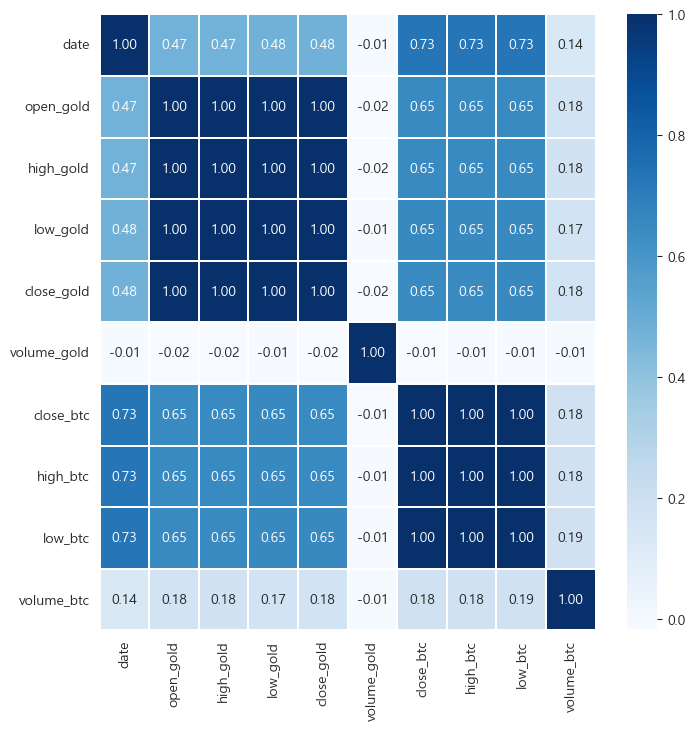

In [148]:
#히트맵

colormap=plt.cm.gist_heat
plt.figure(figsize=(8,8))
sns.heatmap(df_train.corr(),linewidths=0.1,vmax=1,cmap='Blues',linecolor='white',annot=True,fmt='.2f')
plt.show()

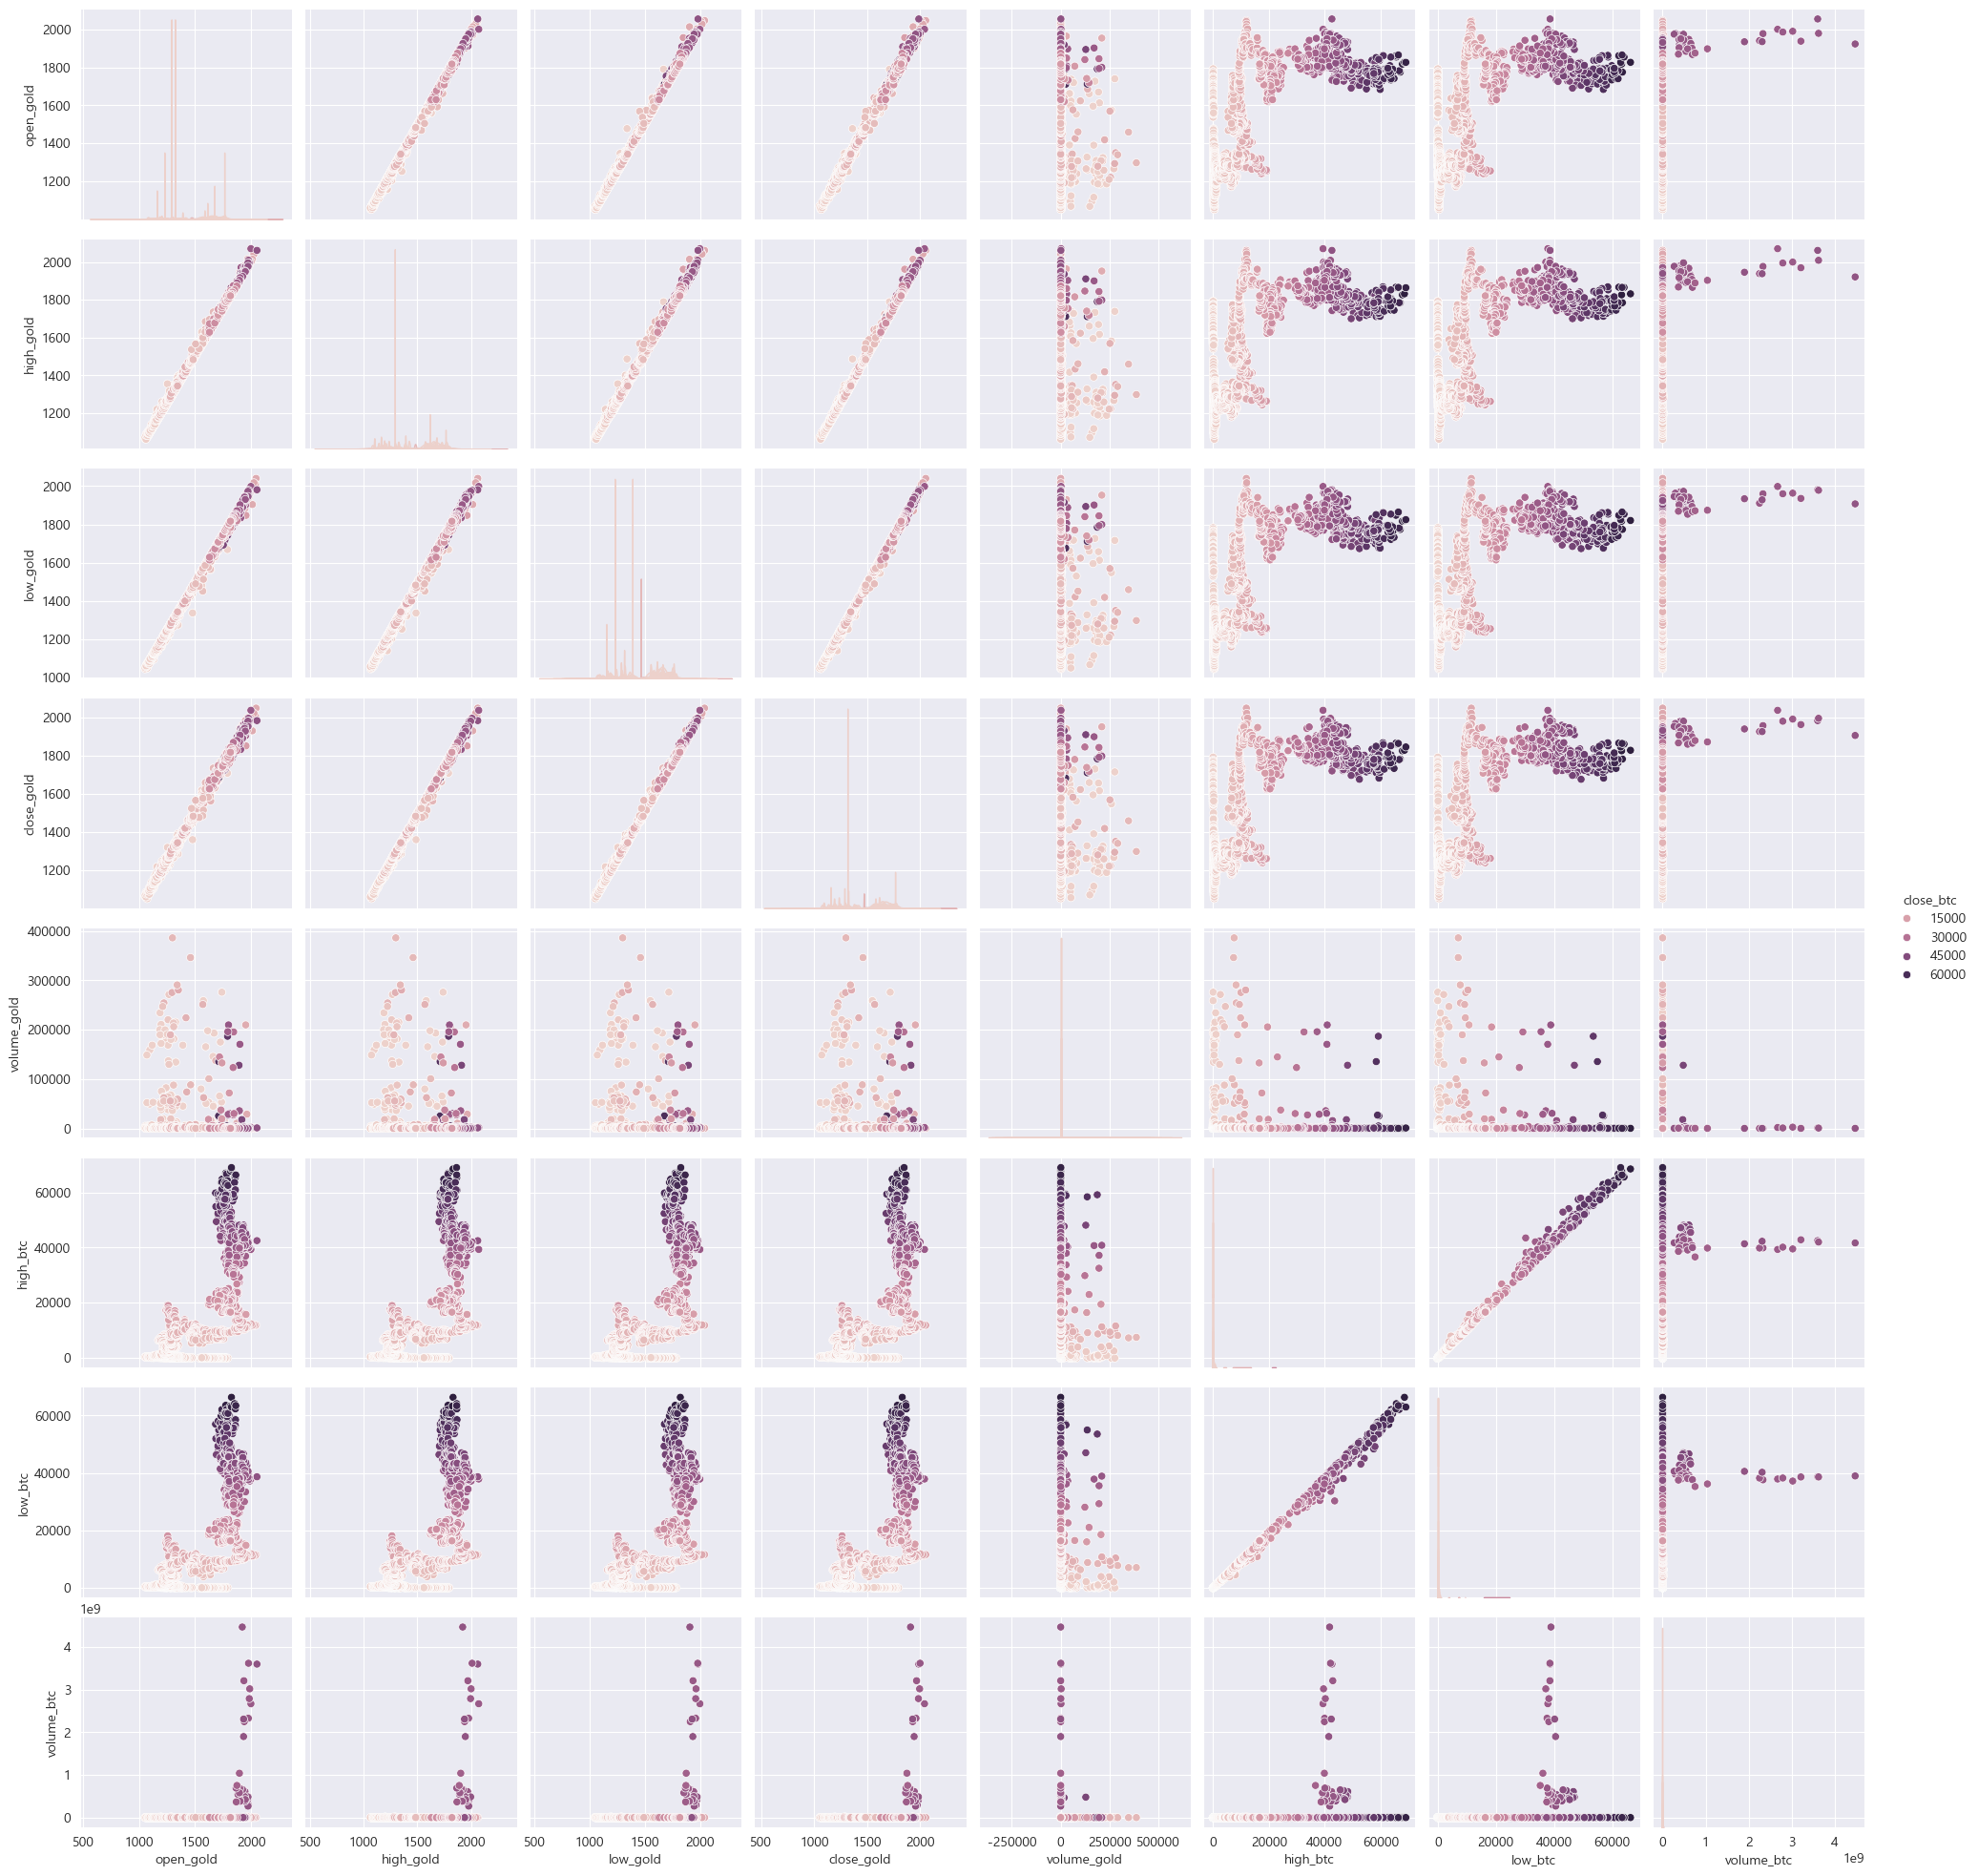

In [91]:
sns.pairplot(df_train,hue='close_btc')
plt.show()

In [149]:
# 상관계수 체크

print(f'비트코인과 금값 상관계수 : {np.corrcoef(df_train.close_gold, df_train.close_btc)[0,1]}')

비트코인과 금값 상관계수 : 0.6497510785139097


Text(0, 0.5, 'USD($)')

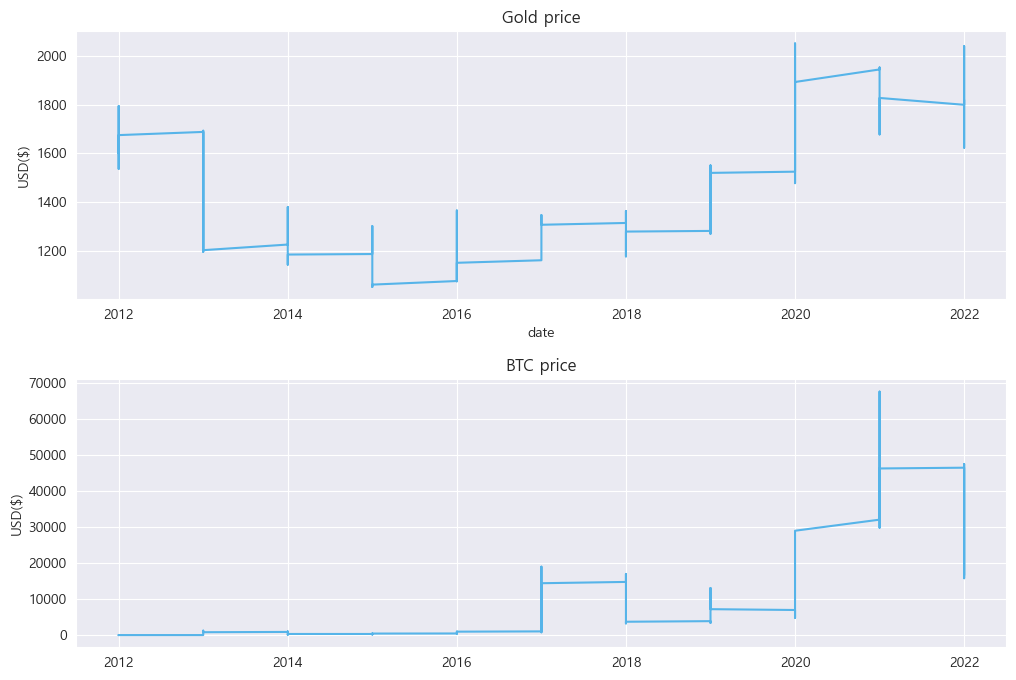

In [150]:
# 년도별 금값, 비트코인 그래프

fig, axs = plt.subplots(2,1,figsize = (12,8))
fig.subplots_adjust(hspace=0.3)
# plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(df_train['date'].dt.year,df_train['close_gold'],color='#56b4e9')
plt.title('Gold price')
plt.xlabel('date')
plt.ylabel('USD($)')

plt.subplot(2,1,2)
plt.plot(df_train['date'].dt.year,df_train['close_btc'],color='#56b4e9')
plt.title('BTC price')
plt.ylabel('USD($)')

In [151]:
#트레이닝/테스트 데이터 쪼개기

X_train = df_train.drop(['close_btc','date'], axis=1).astype(float)
y_train = df_train['close_btc'].values.astype(float)
X_test=df_test.drop(['close_btc','date'], axis=1).astype(float)
y_test=df_test['close_btc'].values.astype(float)

In [152]:
# 모델 성능 지표 분석

def evaluate_model(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    mae = mean_absolute_error(y_test, y_predict)
    r2 = r2_score(y_test, y_predict)
    rmse = np.sqrt(mse)
    return mse, mae, r2, rmse

In [153]:
def predict_to_graph(y_test, y_predict):
    actual_temp = []
    pred_temp = []
    X_num = []
    count = 0
    for i in range(300):
        actual = y_test[i]
        prediction = y_predict[i]
        print("실제btc: {:.2f}, 예상btc: {:.2f}".format(actual, prediction))
        actual_temp.append(actual)
        pred_temp.append(prediction)
        count += 1
        X_num.append(count)

    plt.plot(X_num, pred_temp, label='Predicted btc',color='#56b4e9')
    plt.plot(X_num, actual_temp, label='Actual btc',color='#d55e00',alpha=0.8)
    plt.legend(loc='upper left')

In [154]:
# 예측값 시각화

def plot_results(X_test, y_test, y_predict, model_name):
    plt.figure(figsize=(12, 12))
    
    plt.subplot(3, 1, 1)
    plt.scatter(X_test['close_gold'], y_test, color='#56b4e9', alpha=0.5, label='Actual')
    plt.scatter(X_test['close_gold'], y_predict, color='#D55E00', alpha=0.5, label='Predicted')
    plt.xlabel('Gold')
    plt.ylabel('BTC')
    plt.title(model_name)
    plt.legend()
    
    plt.subplot(3, 1, 2)
    sns.kdeplot(y_test, color='#56b4e9', label="Actual")
    sns.kdeplot(y_predict, label='Predicted', color='#D55E00')
    plt.legend(loc='upper left')
    
    plt.subplot(3, 1, 3)
    predict_to_graph(y_test, y_predict)
    
    plt.tight_layout()
    plt.show()

실제btc: 16674.20, 예상btc: 16675.26
실제btc: 16852.10, 예상btc: 16821.37
실제btc: 16829.80, 예상btc: 16826.10
실제btc: 16950.90, 예상btc: 16897.86
실제btc: 17180.10, 예상btc: 17251.03
실제btc: 17439.10, 예상btc: 17312.81
실제btc: 17942.30, 예상btc: 17657.72
실제btc: 18851.30, 예상btc: 18527.88
실제btc: 19927.00, 예상btc: 19402.02
실제btc: 21137.10, 예상btc: 21223.66
실제btc: 20670.60, 예상btc: 21032.82
실제btc: 21081.20, 예상btc: 20919.71
실제btc: 22677.20, 예상btc: 21838.63
실제btc: 22915.50, 예상btc: 22853.26
실제btc: 22632.50, 예상btc: 22834.36
실제btc: 23055.10, 예상btc: 23088.99
실제btc: 23016.00, 예상btc: 23058.99
실제btc: 23074.60, 예상btc: 23033.01
실제btc: 22832.20, 예상btc: 23202.31
실제btc: 23125.10, 예상btc: 23027.07
실제btc: 23725.60, 예상btc: 23344.26
실제btc: 23427.60, 예상btc: 23857.05
실제btc: 23431.20, 예상btc: 23515.49
실제btc: 22761.80, 예상btc: 22892.16
실제btc: 23251.70, 예상btc: 23044.28
실제btc: 22964.60, 예상btc: 23065.42
실제btc: 21792.50, 예상btc: 22417.98
실제btc: 21635.00, 예상btc: 21714.85
실제btc: 21772.60, 예상btc: 21653.31
실제btc: 22198.50, 예상btc: 21950.30
실제btc: 243

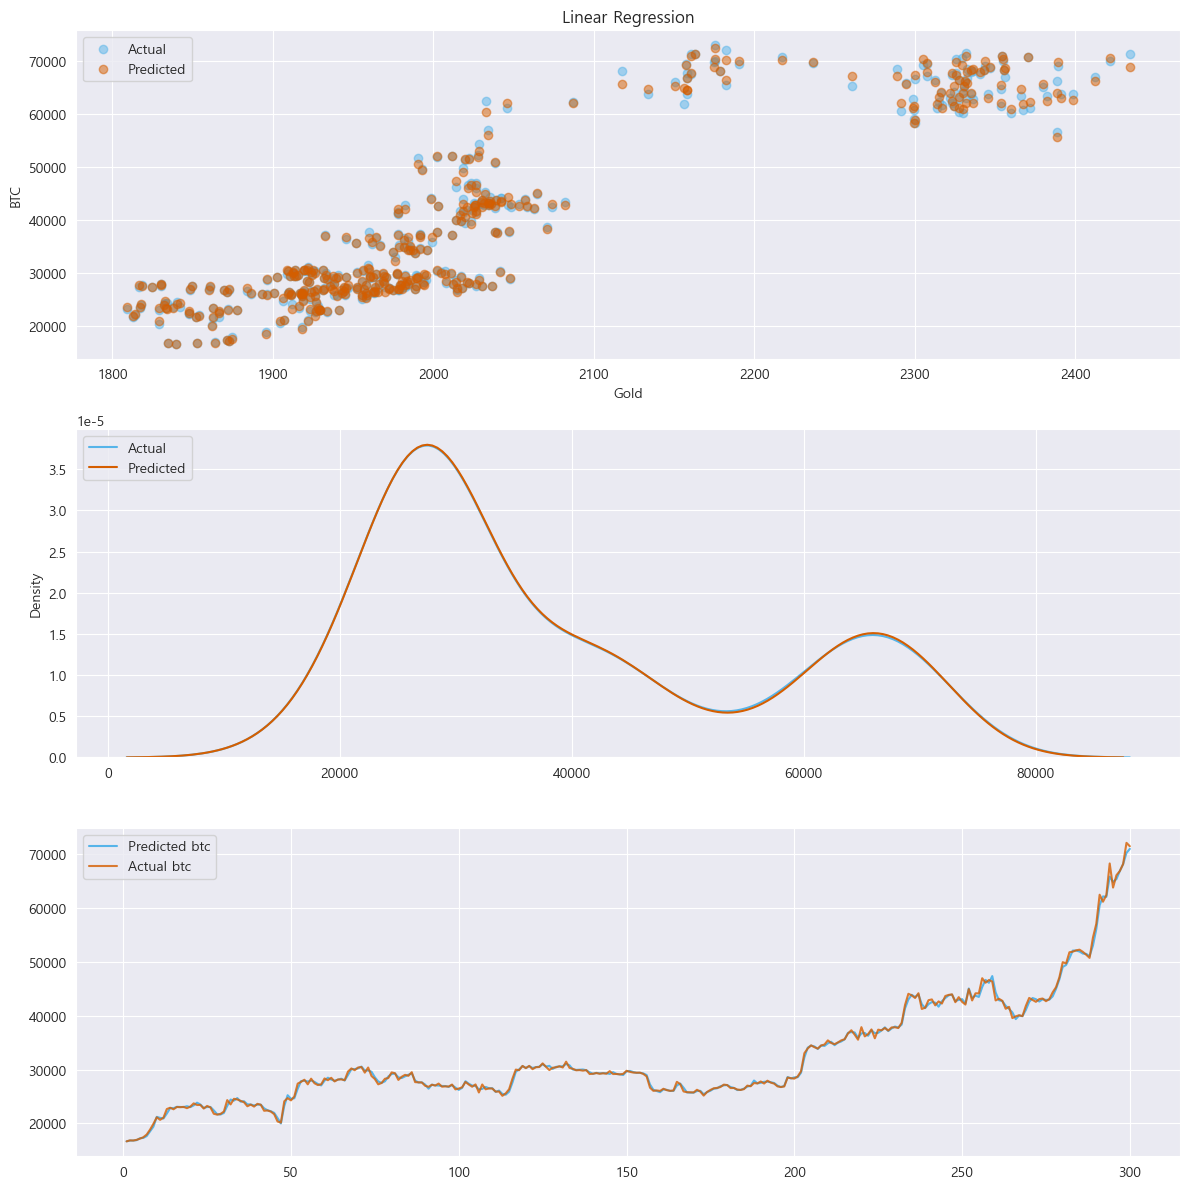

Linear Regression - MSE: 360262.1595561811, MAE: 401.31895351244566, R2: 0.9986654408329814, RMSE: 600.218426538357


In [155]:
# 선형회귀 모델

def linear_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse, mae, r2, rmse = evaluate_model(y_test, y_pred)
    plot_results(X_test, y_test, y_pred, 'Linear Regression')
    print(f"Linear Regression - MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")
    return mse, mae, r2, rmse

lr_model = linear_regression_model(X_train, y_train, X_test, y_test)

실제btc: 16674.20, 예상btc: 26853.33
실제btc: 16852.10, 예상btc: 27898.52
실제btc: 16829.80, 예상btc: 26467.87
실제btc: 16950.90, 예상btc: 28825.38
실제btc: 17180.10, 예상btc: 29526.96
실제btc: 17439.10, 예상btc: 29435.67
실제btc: 17942.30, 예상btc: 29685.01
실제btc: 18851.30, 예상btc: 31453.14
실제btc: 19927.00, 예상btc: 33452.70
실제btc: 21137.10, 예상btc: 32466.61
실제btc: 20670.60, 예상btc: 32222.53
실제btc: 21081.20, 예상btc: 33781.87
실제btc: 22677.20, 예상btc: 34166.57
실제btc: 22915.50, 예상btc: 34229.41
실제btc: 22632.50, 예상btc: 34843.04
실제btc: 23055.10, 예상btc: 35508.17
실제btc: 23016.00, 예상btc: 34409.29
실제btc: 23074.60, 예상btc: 34364.27
실제btc: 22832.20, 예상btc: 33853.27
실제btc: 23125.10, 예상btc: 34445.33
실제btc: 23725.60, 예상btc: 34292.32
실제btc: 23427.60, 예상btc: 33266.62
실제btc: 23431.20, 예상btc: 28718.87
실제btc: 22761.80, 예상btc: 28989.65
실제btc: 23251.70, 예상btc: 29443.96
실제btc: 22964.60, 예상btc: 29918.75
실제btc: 21792.50, 예상btc: 28989.65
실제btc: 21635.00, 예상btc: 28710.69
실제btc: 21772.60, 예상btc: 27826.03
실제btc: 22198.50, 예상btc: 27995.32
실제btc: 243

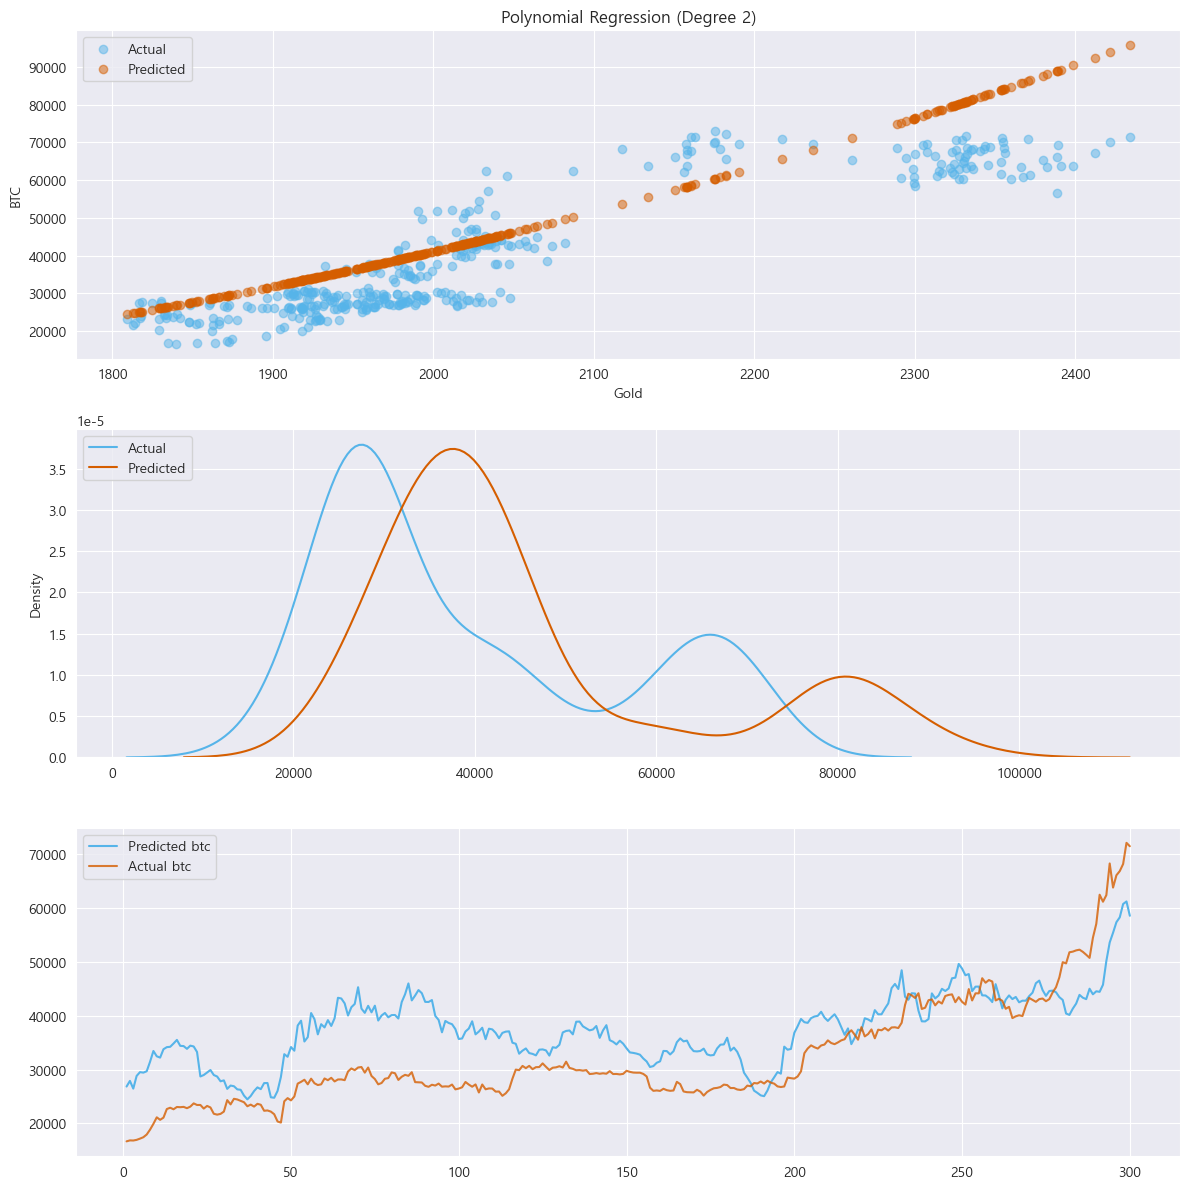

Polynomial Regression (Degree 2) - MSE: 107425350.32777412, MAE: 8655.066378541409, R2: 0.602052332593745, RMSE: 10364.620124624642


In [156]:
# 다항선형회귀 모델

def polynomial_regression_model(X_train, y_train, X_test, y_test, degree=2):
    X_train_poly = X_train[['close_gold']].values.reshape(-1, 1)
    X_test_poly = X_test[['close_gold']].values.reshape(-1, 1)
    
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    
    mse, mae, r2, rmse = evaluate_model(y_test, y_pred)
    plot_results(X_test, y_test, y_pred, f'Polynomial Regression (Degree {degree})')
    print(f"Polynomial Regression (Degree {degree}) - MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")
    return mse, mae, r2, rmse

poly_model = polynomial_regression_model(X_train, y_train, X_test, y_test)

# 결정 트리 (Decision Tree)
설명: 데이터를 조건에 따라 분할하여 예측하는 모델입니다.  
장점: 직관적이며 해석이 쉬움.  
단점: 과적합의 위험이 있음

실제btc: 16674.20, 예상btc: 16831.80
실제btc: 16852.10, 예상btc: 16706.10
실제btc: 16829.80, 예상btc: 16831.80
실제btc: 16950.90, 예상btc: 16706.10
실제btc: 17180.10, 예상btc: 17778.60
실제btc: 17439.10, 예상btc: 17774.60
실제btc: 17942.30, 예상btc: 17796.40
실제btc: 18851.30, 예상btc: 18675.20
실제btc: 19927.00, 예상btc: 18658.10
실제btc: 21137.10, 예상btc: 22157.30
실제btc: 20670.60, 예상btc: 21352.20
실제btc: 21081.20, 예상btc: 20720.40
실제btc: 22677.20, 예상btc: 22157.30
실제btc: 22915.50, 예상btc: 22157.30
실제btc: 22632.50, 예상btc: 22157.30
실제btc: 23055.10, 예상btc: 22675.20
실제btc: 23016.00, 예상btc: 23257.90
실제btc: 23074.60, 예상btc: 23410.20
실제btc: 22832.20, 예상btc: 23410.20
실제btc: 23125.10, 예상btc: 22988.60
실제btc: 23725.60, 예상btc: 23410.20
실제btc: 23427.60, 예상btc: 24398.70
실제btc: 23431.20, 예상btc: 24398.70
실제btc: 22761.80, 예상btc: 22157.30
실제btc: 23251.70, 예상btc: 23257.90
실제btc: 22964.60, 예상btc: 23257.90
실제btc: 21792.50, 예상btc: 22157.30
실제btc: 21635.00, 예상btc: 22157.30
실제btc: 21772.60, 예상btc: 22157.30
실제btc: 22198.50, 예상btc: 22157.30
실제btc: 243

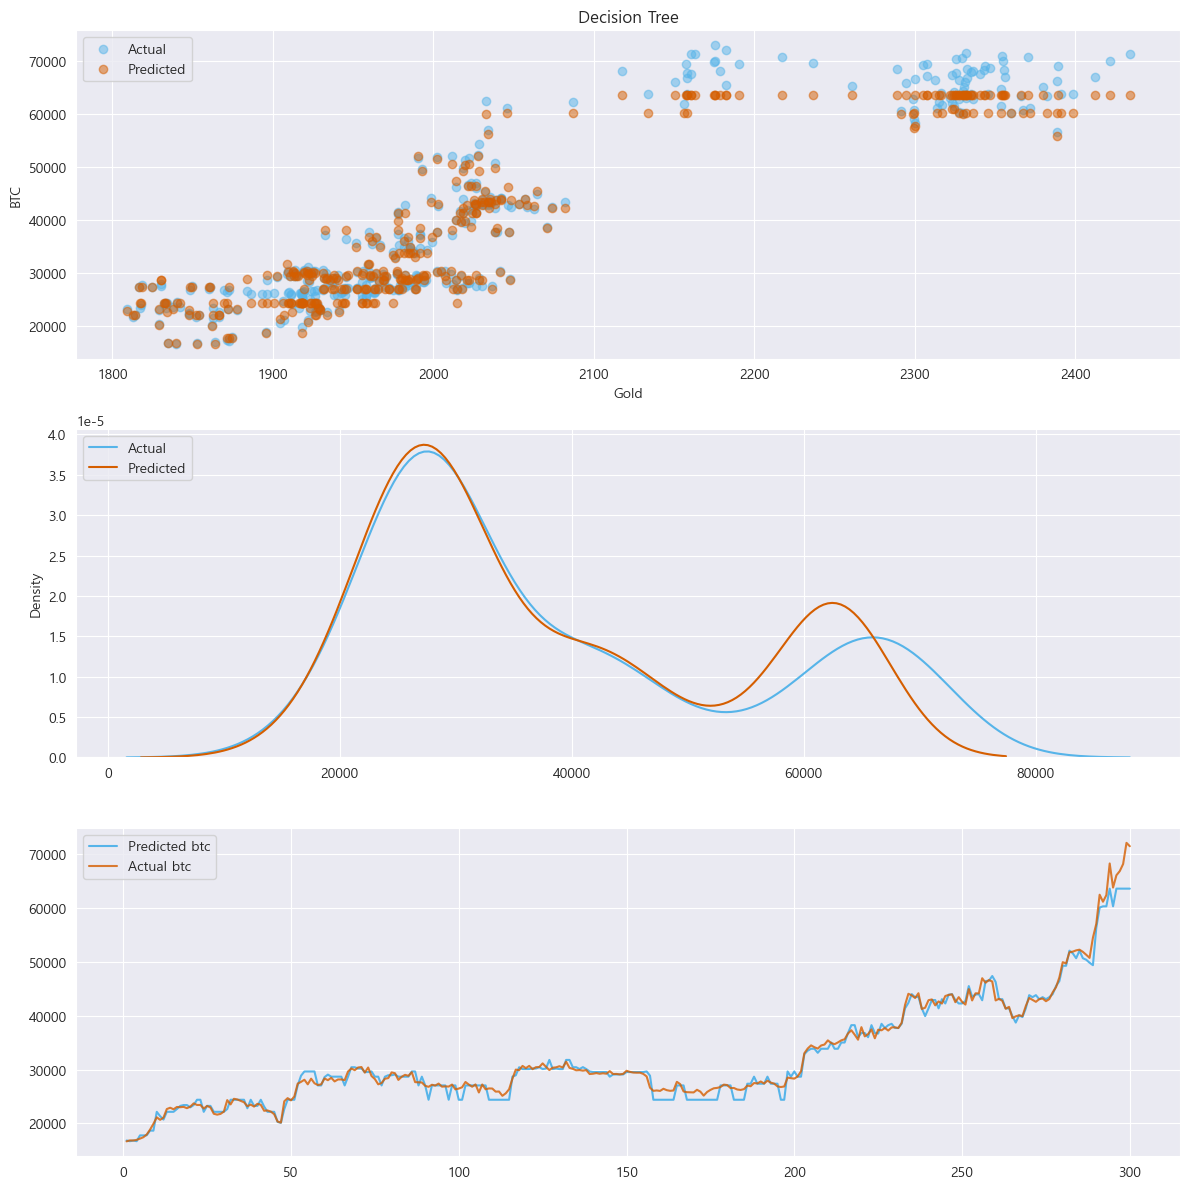

Decision Tree - MSE: 5163356.143562004, MAE: 1383.767018469657, R2: 0.980872805840997, RMSE: 2272.301948149058


In [157]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree_model(X_train, y_train, X_test, y_test):
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse, mae, r2, rmse = evaluate_model(y_test, y_pred)
    plot_results(X_test, y_test, y_pred, 'Decision Tree')
    print(f"Decision Tree - MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")
    return mse, mae, r2, rmse

dt_model = decision_tree_model(X_train, y_train, X_test, y_test)

# 랜덤 포레스트 (Random Forest)
설명: 여러 개의 결정 트리를 앙상블하여 예측하는 모델입니다.  
장점: 과적합 방지, 높은 예측 성능.  
단점: 모델이 복잡해질 수 있음.

실제btc: 16674.20, 예상btc: 16749.27
실제btc: 16852.10, 예상btc: 16768.24
실제btc: 16829.80, 예상btc: 16814.24
실제btc: 16950.90, 예상btc: 16828.60
실제btc: 17180.10, 예상btc: 17210.72
실제btc: 17439.10, 예상btc: 17238.19
실제btc: 17942.30, 예상btc: 17752.39
실제btc: 18851.30, 예상btc: 18452.49
실제btc: 19927.00, 예상btc: 18987.06
실제btc: 21137.10, 예상btc: 21362.57
실제btc: 20670.60, 예상btc: 21077.58
실제btc: 21081.20, 예상btc: 20952.71
실제btc: 22677.20, 예상btc: 21906.92
실제btc: 22915.50, 예상btc: 22542.57
실제btc: 22632.50, 예상btc: 22535.46
실제btc: 23055.10, 예상btc: 22935.24
실제btc: 23016.00, 예상btc: 23217.06
실제btc: 23074.60, 예상btc: 23261.10
실제btc: 22832.20, 예상btc: 23309.16
실제btc: 23125.10, 예상btc: 23253.19
실제btc: 23725.60, 예상btc: 23473.68
실제btc: 23427.60, 예상btc: 23886.62
실제btc: 23431.20, 예상btc: 23394.02
실제btc: 22761.80, 예상btc: 22656.65
실제btc: 23251.70, 예상btc: 23258.56
실제btc: 22964.60, 예상btc: 23167.13
실제btc: 21792.50, 예상btc: 22373.99
실제btc: 21635.00, 예상btc: 21598.81
실제btc: 21772.60, 예상btc: 21558.84
실제btc: 22198.50, 예상btc: 21915.96
실제btc: 243

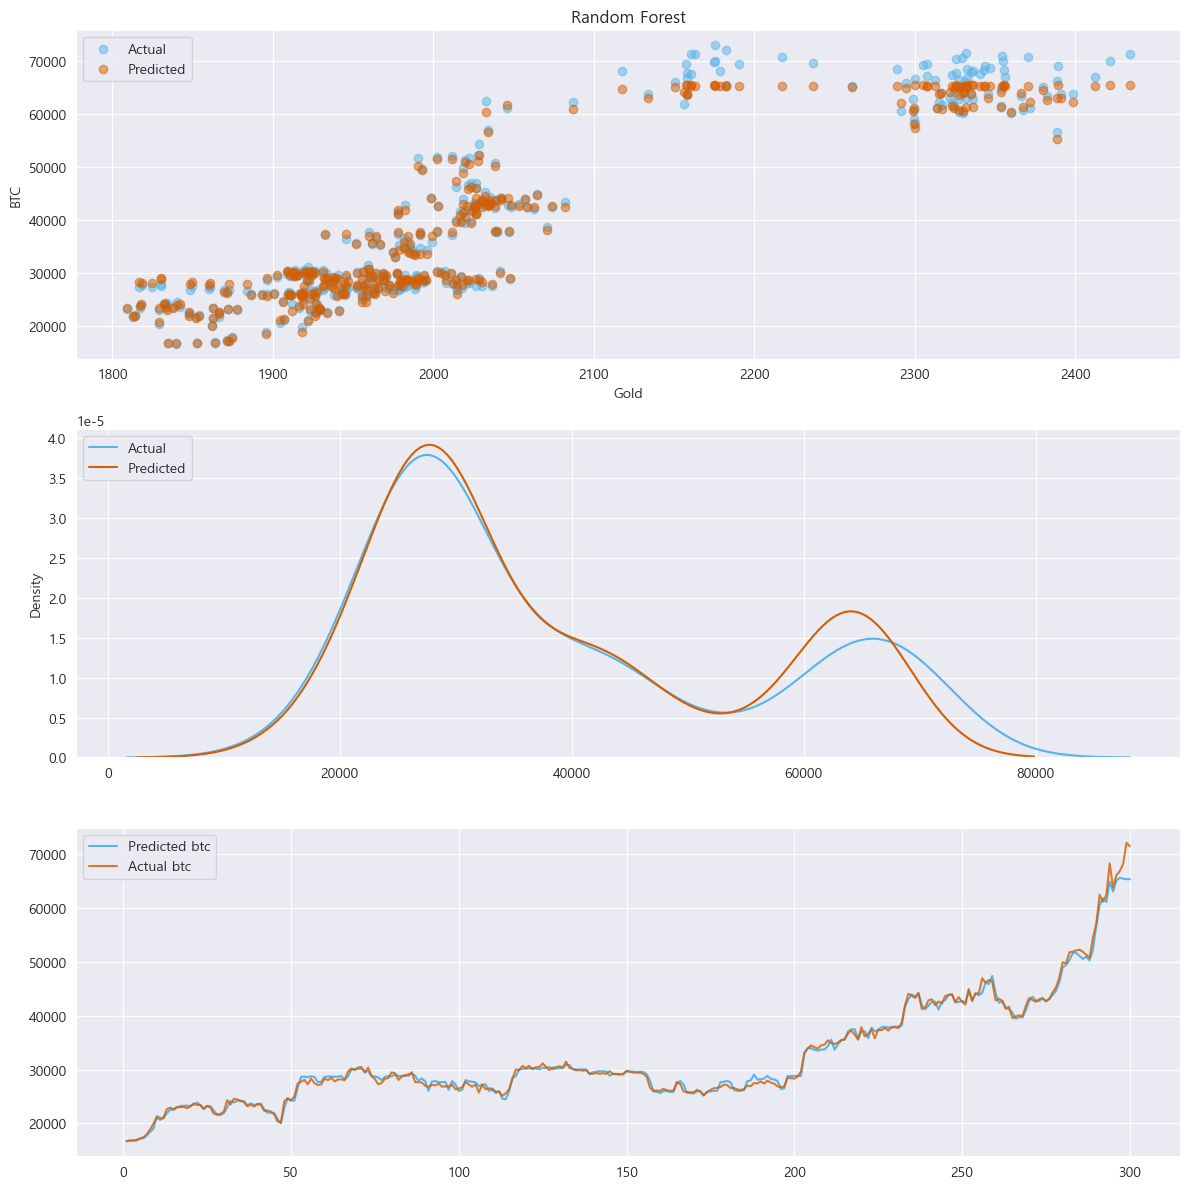

Random Forest - MSE: 2328525.4054656015, MAE: 889.1506649076455, R2: 0.9913741844846312, RMSE: 1525.9506563010489


In [158]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_model(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse, mae, r2, rmse = evaluate_model(y_test, y_pred)
    plot_results(X_test, y_test, y_pred, 'Random Forest')
    print(f"Random Forest - MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")
    return mse, mae, r2, rmse

rf_model = random_forest_model(X_train, y_train, X_test, y_test)

# XGBoost
적합한 경우: 성능이 중요한 복잡한 데이터셋.  
장점: 높은 성능, 빠른 학습 속도, 내결함성.  
단점: 하이퍼파라미터 조정이 필요할 수 있음.

실제btc: 16674.20, 예상btc: 16545.11
실제btc: 16852.10, 예상btc: 17029.77
실제btc: 16829.80, 예상btc: 17062.46
실제btc: 16950.90, 예상btc: 16943.82
실제btc: 17180.10, 예상btc: 17147.46
실제btc: 17439.10, 예상btc: 17090.42
실제btc: 17942.30, 예상btc: 18048.70
실제btc: 18851.30, 예상btc: 18365.52
실제btc: 19927.00, 예상btc: 19367.20
실제btc: 21137.10, 예상btc: 22063.10
실제btc: 20670.60, 예상btc: 21446.25
실제btc: 21081.20, 예상btc: 21917.55
실제btc: 22677.20, 예상btc: 20845.58
실제btc: 22915.50, 예상btc: 22953.17
실제btc: 22632.50, 예상btc: 22927.69
실제btc: 23055.10, 예상btc: 22921.93
실제btc: 23016.00, 예상btc: 23503.71
실제btc: 23074.60, 예상btc: 23627.57
실제btc: 22832.20, 예상btc: 22985.79
실제btc: 23125.10, 예상btc: 23622.27
실제btc: 23725.60, 예상btc: 23710.00
실제btc: 23427.60, 예상btc: 22742.25
실제btc: 23431.20, 예상btc: 22799.20
실제btc: 22761.80, 예상btc: 23154.71
실제btc: 23251.70, 예상btc: 22572.92
실제btc: 22964.60, 예상btc: 23242.57
실제btc: 21792.50, 예상btc: 21450.85
실제btc: 21635.00, 예상btc: 21562.61
실제btc: 21772.60, 예상btc: 21850.17
실제btc: 22198.50, 예상btc: 21534.50
실제btc: 243

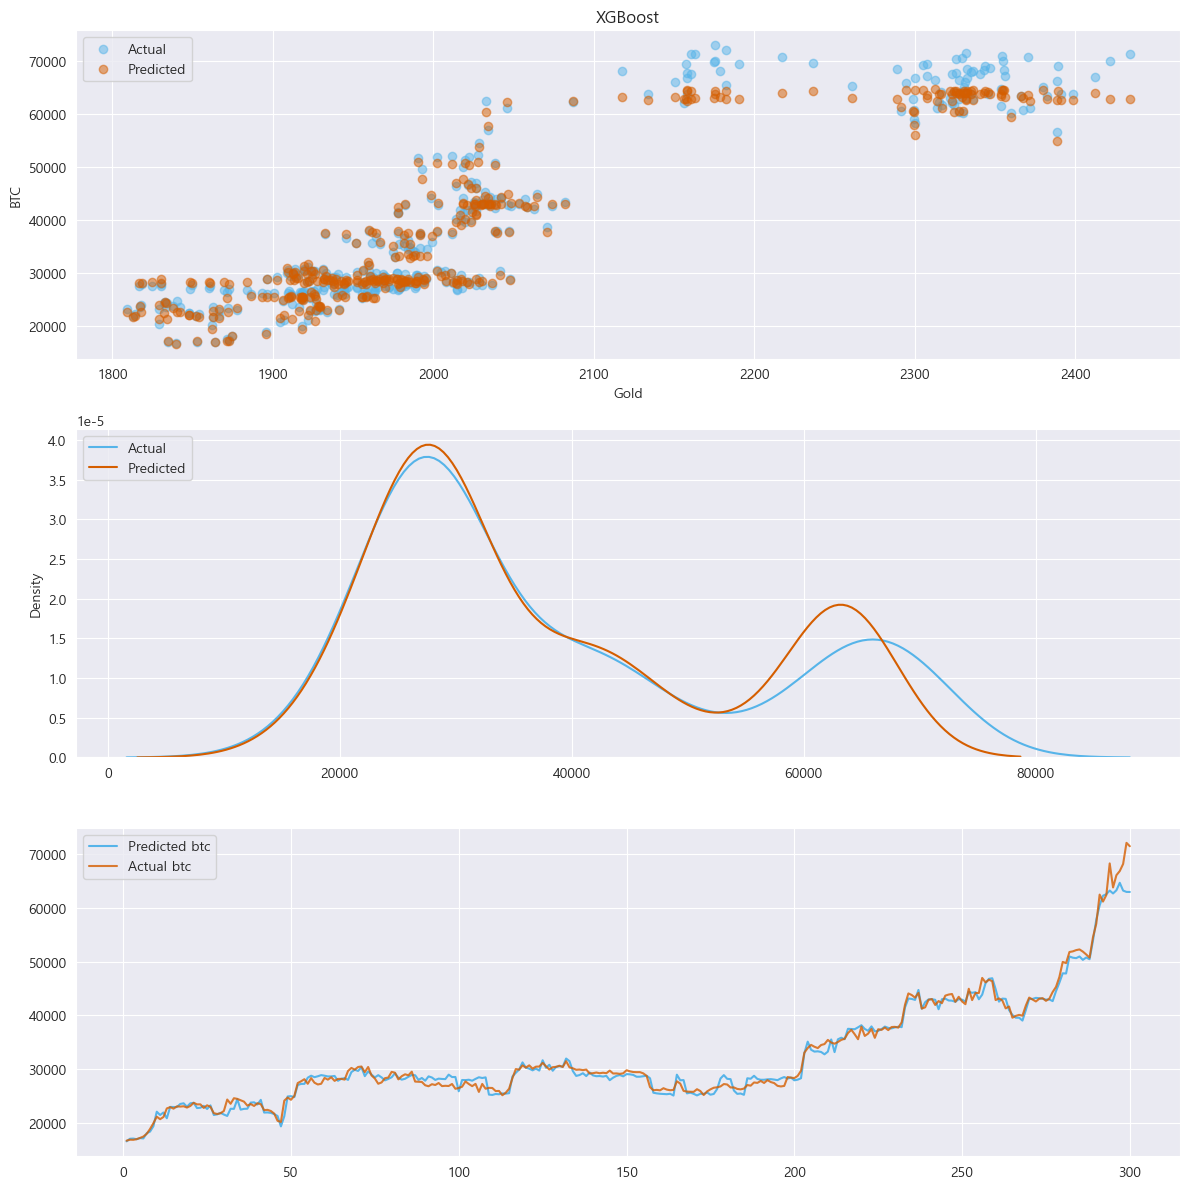

XGBoost - MSE: 4588014.900274458, MAE: 1311.1239250082458, R2: 0.9830041063676447, RMSE: 2141.965195859741


In [159]:
from xgboost import XGBRegressor

def xgboost_model(X_train, y_train, X_test, y_test):
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse, mae, r2, rmse = evaluate_model(y_test, y_pred)
    plot_results(X_test, y_test, y_pred, 'XGBoost')
    print(f"XGBoost - MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")
    return mse, mae, r2, rmse

xb_model = xgboost_model(X_train, y_train, X_test, y_test)

# Gradient Boosting Machines (GBM)
적합한 경우: 예측 성능이 중요한 경우, 복잡한 비선형 관계가 있을 때.  
장점: 높은 성능과 유연성.  
단점: 하이퍼파라미터 튜닝이 필요할 수 있음.

실제btc: 16674.20, 예상btc: 16665.24
실제btc: 16852.10, 예상btc: 16854.03
실제btc: 16829.80, 예상btc: 16854.03
실제btc: 16950.90, 예상btc: 16854.03
실제btc: 17180.10, 예상btc: 17457.82
실제btc: 17439.10, 예상btc: 17457.82
실제btc: 17942.30, 예상btc: 17913.28
실제btc: 18851.30, 예상btc: 18523.97
실제btc: 19927.00, 예상btc: 19205.86
실제btc: 21137.10, 예상btc: 21784.40
실제btc: 20670.60, 예상btc: 21289.98
실제btc: 21081.20, 예상btc: 20860.53
실제btc: 22677.20, 예상btc: 21915.27
실제btc: 22915.50, 예상btc: 22563.58
실제btc: 22632.50, 예상btc: 22563.58
실제btc: 23055.10, 예상btc: 23461.49
실제btc: 23016.00, 예상btc: 23417.14
실제btc: 23074.60, 예상btc: 23498.46
실제btc: 22832.20, 예상btc: 23544.24
실제btc: 23125.10, 예상btc: 23498.46
실제btc: 23725.60, 예상btc: 23544.24
실제btc: 23427.60, 예상btc: 23544.24
실제btc: 23431.20, 예상btc: 23487.94
실제btc: 22761.80, 예상btc: 22481.12
실제btc: 23251.70, 예상btc: 23300.73
실제btc: 22964.60, 예상btc: 23306.10
실제btc: 21792.50, 예상btc: 21717.53
실제btc: 21635.00, 예상btc: 21586.66
실제btc: 21772.60, 예상btc: 21667.99
실제btc: 22198.50, 예상btc: 21667.99
실제btc: 243

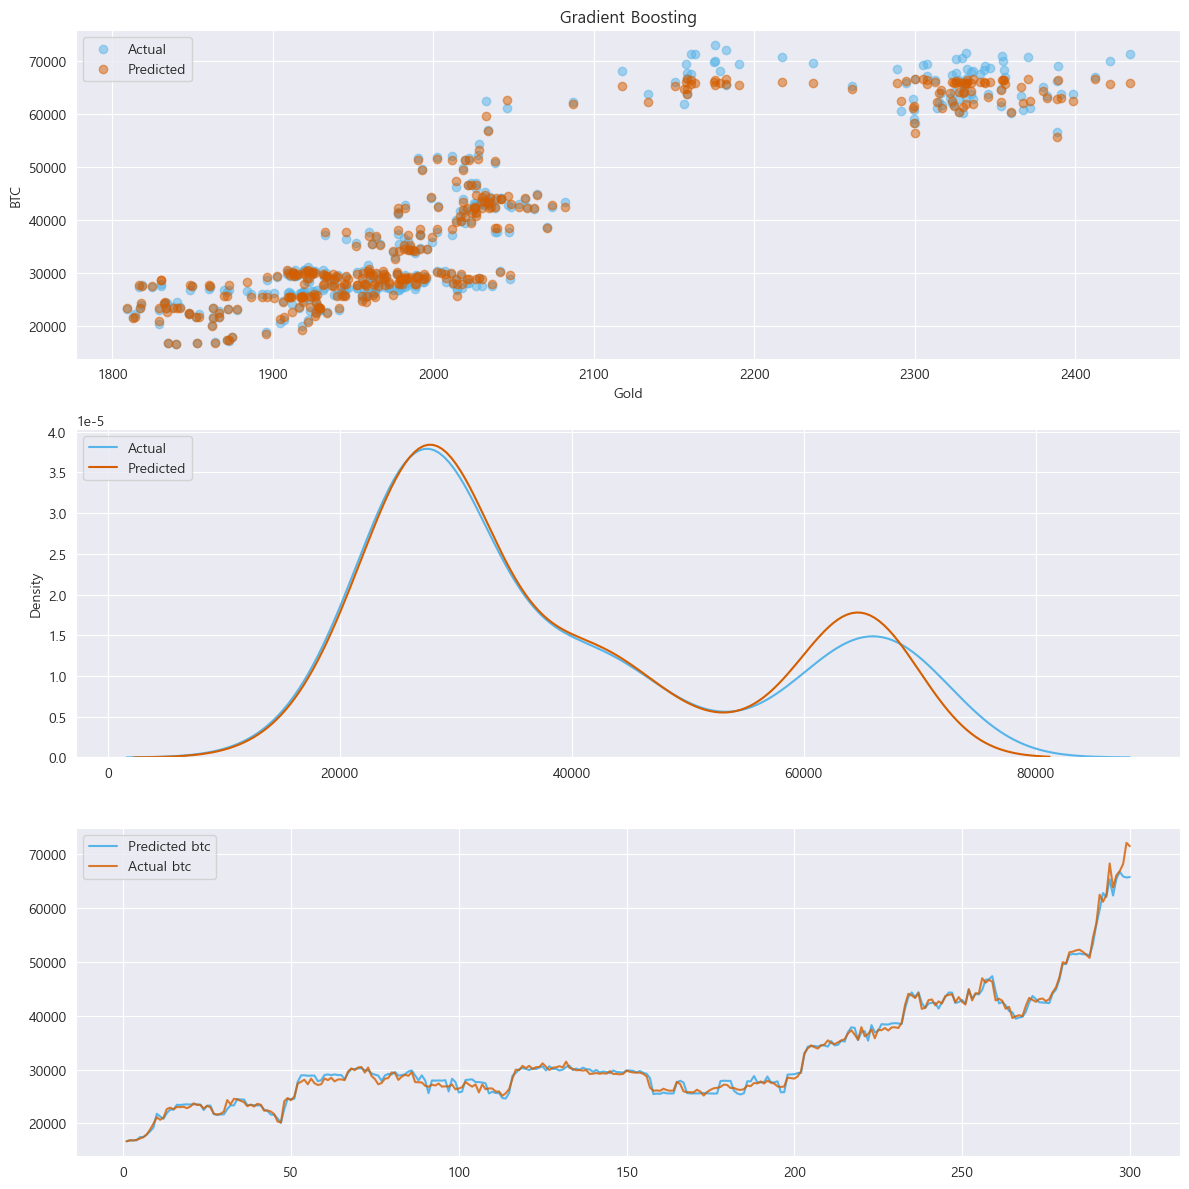

Gradient Boosting - MSE: 1914434.9859066145, MAE: 887.0063455383739, R2: 0.9929081456591211, RMSE: 1383.6310873591322


In [160]:
from sklearn.ensemble import GradientBoostingRegressor

def gradient_boosting_model(X_train, y_train, X_test, y_test):
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse, mae, r2, rmse = evaluate_model(y_test, y_pred)
    plot_results(X_test, y_test, y_pred, 'Gradient Boosting')
    print(f"Gradient Boosting - MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")
    return mse, mae, r2, rmse

gb_model = gradient_boosting_model(X_train, y_train, X_test, y_test)

Epoch 1/2000
116/116 [==============================] - 2s 3ms/step - loss: 153709152.0000 - mae: 4134.0142 - val_loss: 957163392.0000 - val_mae: 27901.0371
Epoch 2/2000
116/116 [==============================] - 0s 2ms/step - loss: 19172750.0000 - mae: 2537.9893 - val_loss: 621625408.0000 - val_mae: 21405.3965
Epoch 3/2000
116/116 [==============================] - 0s 2ms/step - loss: 15967151.0000 - mae: 2315.6746 - val_loss: 561817920.0000 - val_mae: 18421.0898
Epoch 4/2000
116/116 [==============================] - 0s 1ms/step - loss: 7193571.0000 - mae: 1576.3634 - val_loss: 665274112.0000 - val_mae: 18790.3691
Epoch 5/2000
116/116 [==============================] - 0s 2ms/step - loss: 2842977.0000 - mae: 916.5336 - val_loss: 488798688.0000 - val_mae: 15955.2627
Epoch 6/2000
116/116 [==============================] - 0s 1ms/step - loss: 2755108.5000 - mae: 803.6078 - val_loss: 18439868416.0000 - val_mae: 36139.8984
Epoch 7/2000
116/116 [==============================] - 0s 1ms/ste

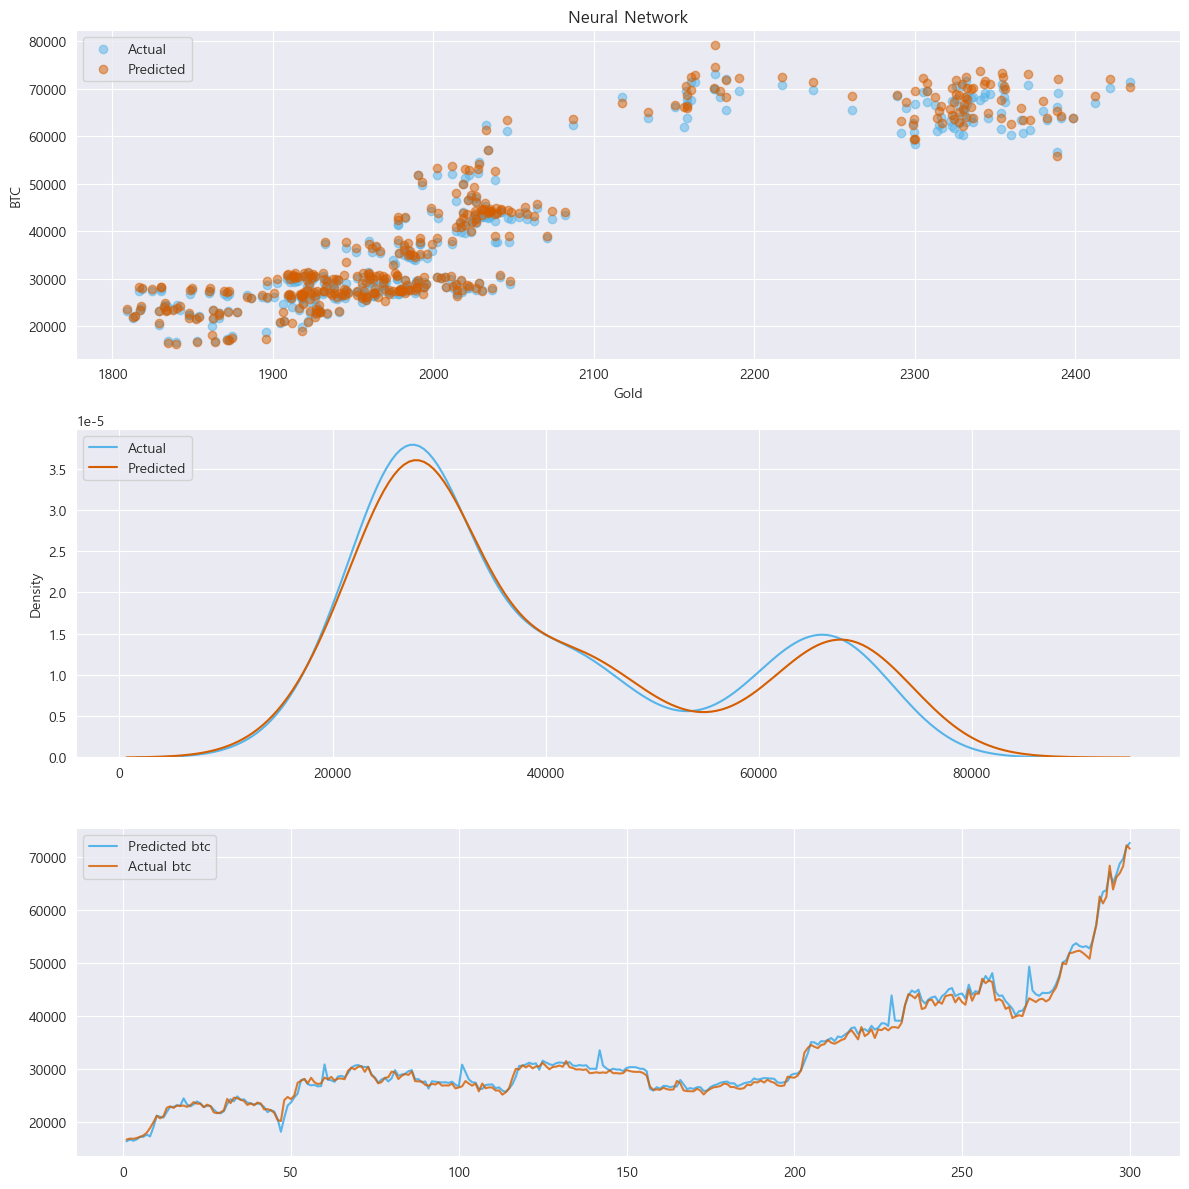

Neural Network - MSE: 2006856.1081405599, MAE: 994.3560577795186, R2: 0.9925657798218225, RMSE: 1416.635488804569


In [161]:
def neural_network_model(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(30, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=42)
    modelpath = "./models/gold_btc.keras"
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)
    
    history = model.fit(X_train, y_train, epochs=2000, batch_size=18, validation_split=0.25,
                        callbacks=[early_stopping_callback, checkpointer])
    
    y_pred = model.predict(X_test).flatten()
    
    mse, mae, r2, rmse = evaluate_model(y_test, y_pred)
    plot_results(X_test, y_test, y_pred, 'Neural Network')
    
    print(f"Neural Network - MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")
    return mse, mae, r2, rmse

ann_model = neural_network_model(X_train, y_train, X_test, y_test)

Epoch 1/500
117/117 [==============================] - 7s 36ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 2/500
117/117 [==============================] - 4s 33ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/500
117/117 [==============================] - 4s 33ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/500
117/117 [==============================] - 4s 35ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/500
117/117 [==============================] - 4s 35ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/500
117/117 [==============================] - 4s 33ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/500
117/117 [==============================] - 4s 33ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 8/500
117/117 [==============================] - 4s 33ms

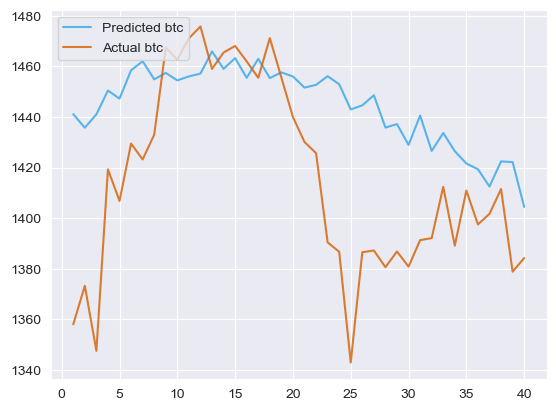

In [139]:
from sklearn.preprocessing import MinMaxScaler
from keras.src.layers import LSTM

df_train=df_train.set_index(keys='date')

# LSTM전용 데이터 전처리

def preprocess_data(df, train_length, predict_days):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df)
    
    X = []
    y = []
    for i in range(len(data_scaled) - train_length - predict_days + 1):
        X.append(data_scaled[i:i + train_length])
        y.append(data_scaled[i + train_length:i + train_length + predict_days, 0])  # 열 수를 1로 변경
    X = np.array(X)
    y = np.array(y)

    # 학습 데이터와 검증 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    y_train = y_train.reshape(-1, predict_days)
    y_test = y_test.reshape(-1, predict_days)

    return X_train, X_test, y_train, y_test, scaler

def lstm_model(X_train, y_train, X_test, y_test, train_length, forecast_days, scaler):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(train_length, X_train.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(forecast_days)) 
    
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=18)    

    history = model.fit(X_train, y_train, epochs=500, batch_size=18, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

    y_pred = model.predict(X_test)

    mse, mae, r2, rmse = evaluate_model(y_test, y_pred)
    print(f"Neural Network - MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")

    y_test_sample = y_test[0].reshape(forecast_days, 1)
    y_pred_sample = y_pred[0].reshape(forecast_days, 1)

    scaler_output = MinMaxScaler()
    scaler_output.fit(df_train[df_train.columns[0]].values.reshape(-1, 1))  # 전체 데이터의 

    y_test_unscaled = scaler_output.inverse_transform(y_test_sample).flatten()
    y_pred_unscaled = scaler_output.inverse_transform(y_pred_sample).flatten()
    
    actual_temp = []
    pred_temp = []
    X_num = []
    count = 0
    for i in range(40):
        actual = y_test_unscaled[i]
        prediction = y_pred_unscaled[i]
        print("실제btc: {:.2f}, 예상btc: {:.2f}".format(actual, prediction))
        actual_temp.append(actual)
        pred_temp.append(prediction)
        count += 1
        X_num.append(count)
    
    plt.plot(X_num, pred_temp, label='Predicted btc',color='#56b4e9')
    plt.plot(X_num, actual_temp, label='Actual btc',color='#d55e00',alpha=0.8)
    plt.legend(loc='upper left')
    
    return r2

X_train, X_val, y_train, y_val, scaler = preprocess_data(df_train.values, 100, 40)
lstm_model=lstm_model(X_train, y_train, X_val, y_val, 100, 40, scaler)


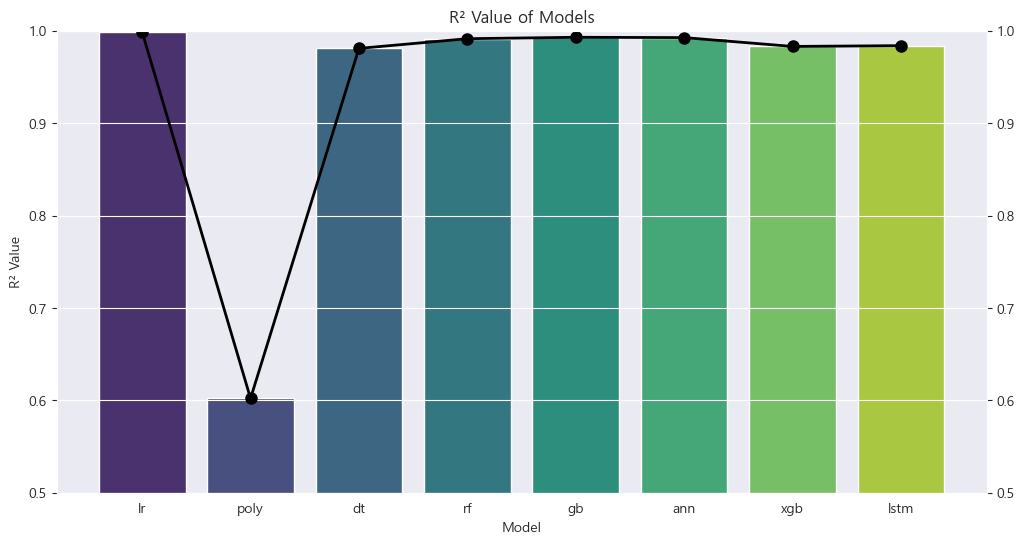

In [165]:
#r2 및 mae 비교

r2_value = {}
r2_value['lr'] = lr_model[2]
r2_value['poly'] = poly_model[2]
r2_value['dt'] = dt_model[2]
r2_value['rf'] = rf_model[2]
r2_value['gb'] = gb_model[2]
r2_value['ann'] = ann_model[2]
r2_value['xgb'] = xb_model[2]
r2_value['lstm'] = lstm_model
def plot_r2_comparison(r2_value):
    plt.figure(figsize=(12, 6))

    ax1 = plt.gca()
    sns.barplot(x=list(r2_value.keys()), y=list(r2_value.values()), palette='viridis', ax=ax1)

    ax2 = ax1.twinx()
    ax2.plot(list(r2_value.keys()), list(r2_value.values()), marker='o', color='black', linestyle='-', linewidth=2,
             markersize=8)

    ax1.set_xlabel('Model')
    ax1.set_ylabel('R² Value')
    ax1.set_title('R² Value of Models')

    ax1.set_ylim(0.5, 1)
    ax2.set_ylim(0.5, 1)

    plt.show()

plot_r2_comparison(r2_value)
